# 1D predictions for 1 hole


In [4]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


In [5]:
two_composite_filtered = pd.read_csv("../Curated_data/two_composite_filtered.csv", low_memory=False)


C:\Users\flea0265\AppData\Local\Temp\ipykernel_18172\324836937.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_composite_1mineral_1hole[['Z', mineral]] = scaler.fit_transform(two_composite_1mineral_1hole[['Z', mineral]])
C:\Users\flea0265\AppData\Local\Temp\ipykernel_18172\324836937.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
C:\Users\flea0265\AppData\Local\Temp\ipykernel_18172\324836937.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than 

- Iteration 0, MSE: 1.002
- Iteration 1000, MSE: 0.018
- Iteration 2000, MSE: 0.017
- Iteration 3000, MSE: 0.017


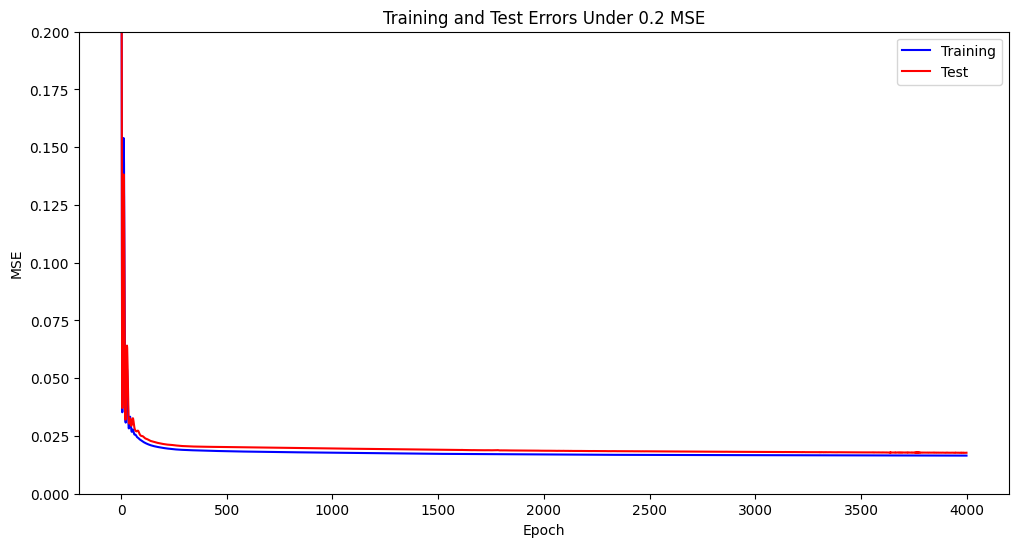

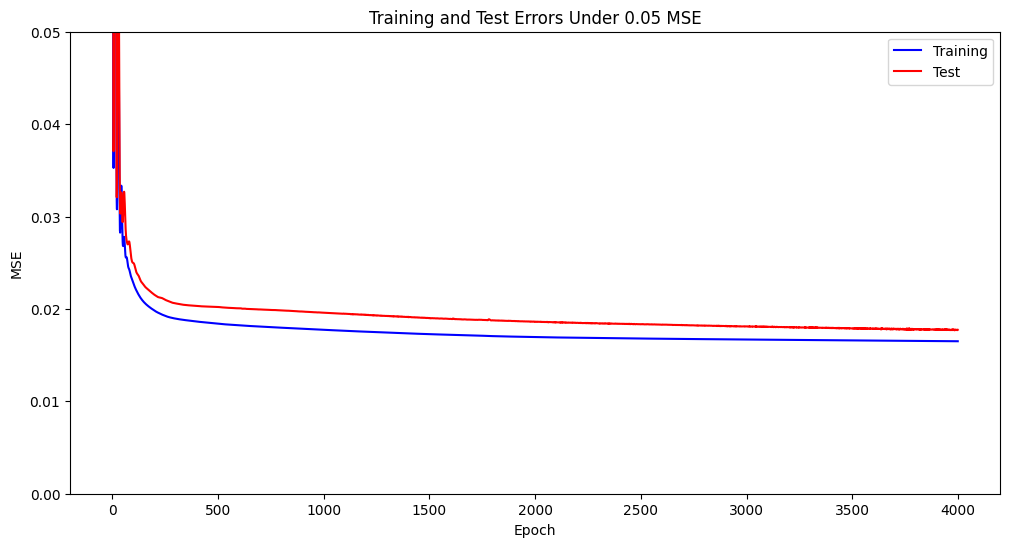

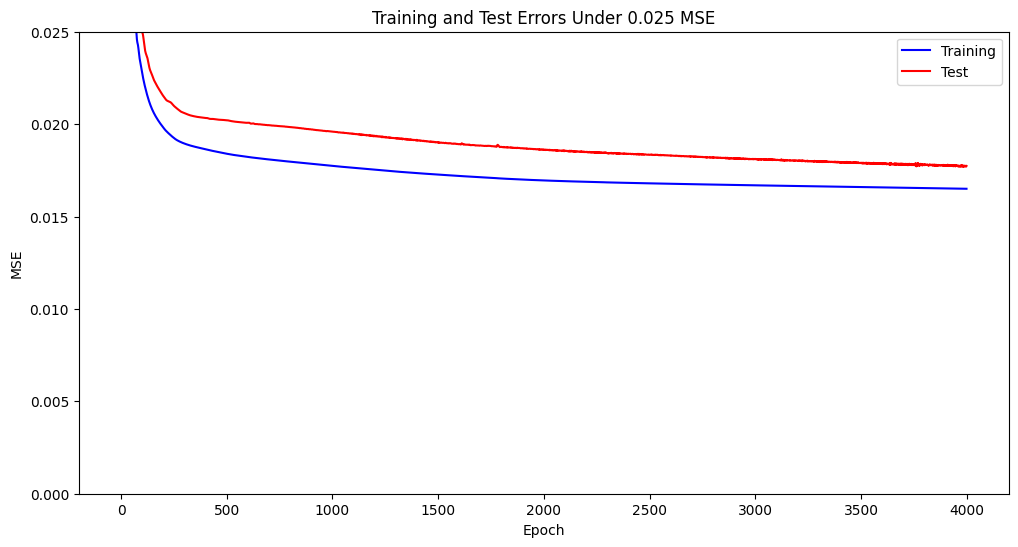

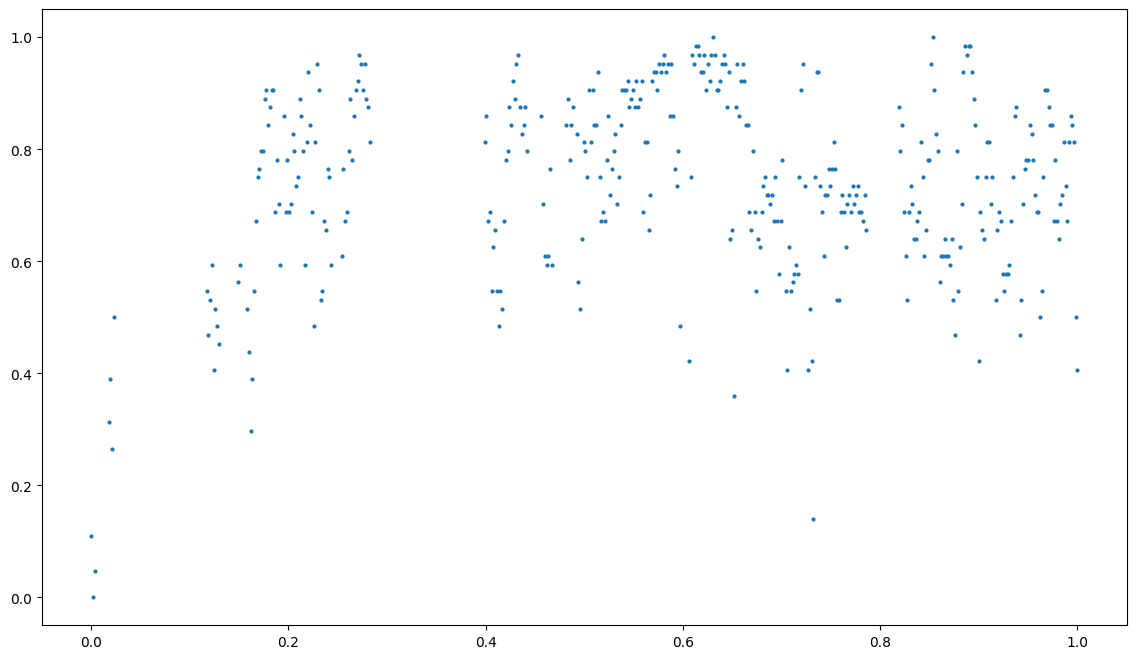

Text(0.5, 1.0, 'Density_gcm3')

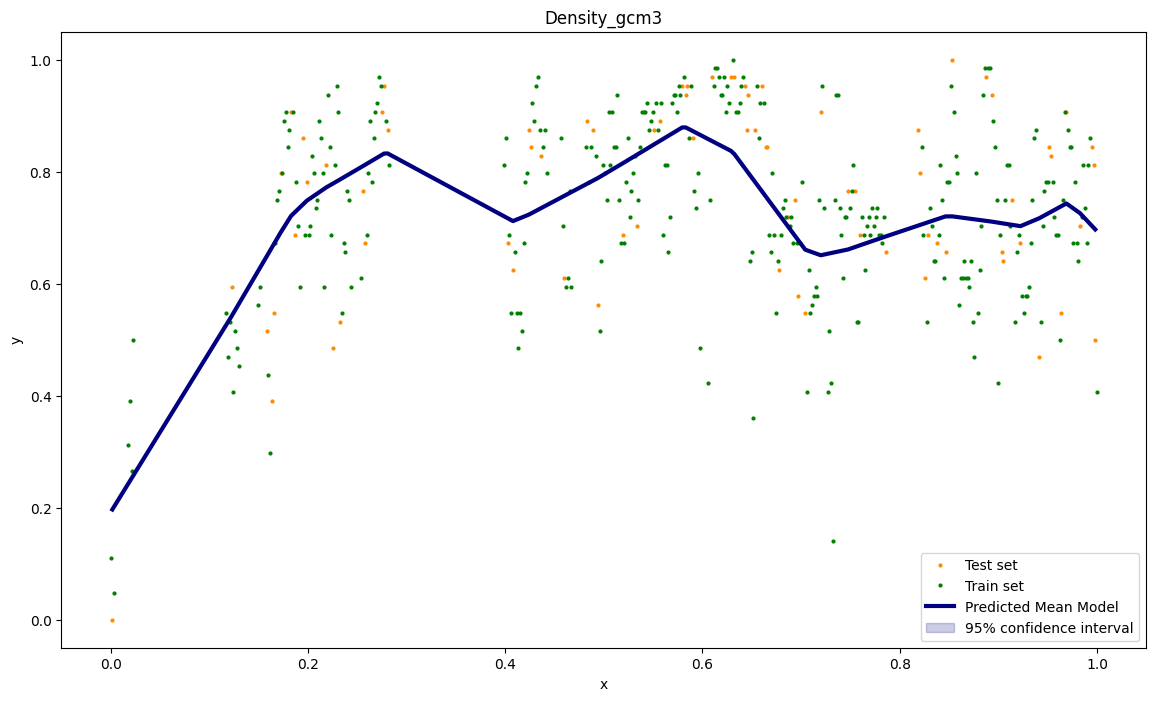

In [6]:
np.random.seed(42)
torch.manual_seed(42)

# mineral = 'Density_gcm3'
# #hole = 'KV-NME001'
# hole = 'KV139'

# two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
# two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral])

# two_composite_1mineral_1hole = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole]

mineral = 'Density_gcm3'
covariates = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
hole = 'KV139'

#Select columns of interest
selected_columns = ["Name", 'X', 'Y', 'Z', mineral] + covariates
two_composite_1mineral = two_composite_filtered[selected_columns]

#Drop NA's and filter for the chosen hole
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral] + covariates)
two_composite_1mineral_1hole = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole]

# # Calculate the mean and standard deviation for the mineral column
# mean_value = two_composite_1mineral_1hole[mineral].mean()
# std_dev = two_composite_1mineral_1hole[mineral].std()

# # Define a threshold for values to be removed (4 standard deviations from the mean)
# threshold = 2 * std_dev

# # Remove rows where the mineral values are above the threshold
# two_composite_1mineral_1hole = two_composite_1mineral_1hole[abs(two_composite_1mineral_1hole[mineral] - mean_value) <= threshold]    

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to your data and transform the specified columns
two_composite_1mineral_1hole[['Z', mineral]] = scaler.fit_transform(two_composite_1mineral_1hole[['Z', mineral]])



two_composite_1mineral_1hole=two_composite_1mineral_1hole.sort_values(by='Z')

x = two_composite_1mineral_1hole[['X','Y', 'Z']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = two_composite_1mineral_1hole[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(two_composite_1mineral_1hole),3)
x = x[:,2].reshape(-1,1)

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]


import matplotlib.pyplot as plt

# Create train and test sets
x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Split the data into train and test sets
test_size = int(0.2 * len(x))
test_indices = np.random.choice(len(x), size=test_size, replace=False)
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]
x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]



model = nn.Sequential(
    nn.Linear(in_features=1, out_features=500),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(4000):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 1000 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.3f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.2)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()



# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.05)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.05 MSE')
plt.show()

# Create a plot showing only values under 0.05 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.025)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.025 MSE')
plt.show()








models_result = np.array([model(x_test).detach().numpy() for k in range(1)])

models_result = models_result[:, :, 0]
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.figure(figsize=(14,8))
plt.scatter(x.data.numpy(), y.data.numpy(), s=4)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=4,label='Train set')



plt.plot(x_test.data.numpy()[:, 0],mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy()[:, 0],mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')



#for x_val in x_test.data.numpy()[:, 0]:
#    plt.vlines(x_val, ymin=y_test.data.numpy()[:,0].min(), ymax=y_test.data.numpy()[:,0].max(), linestyle='--', color='black', alpha=0.1)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(mineral)

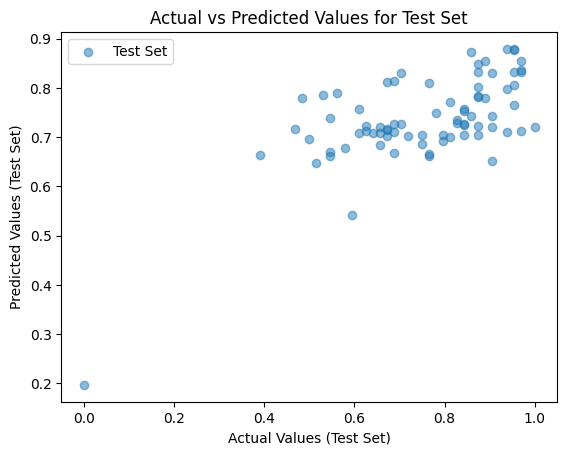

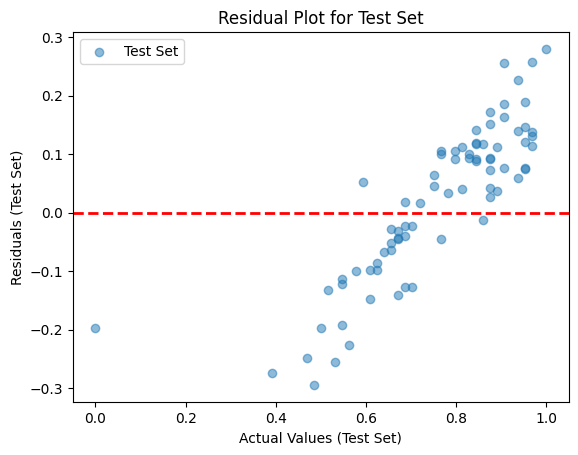

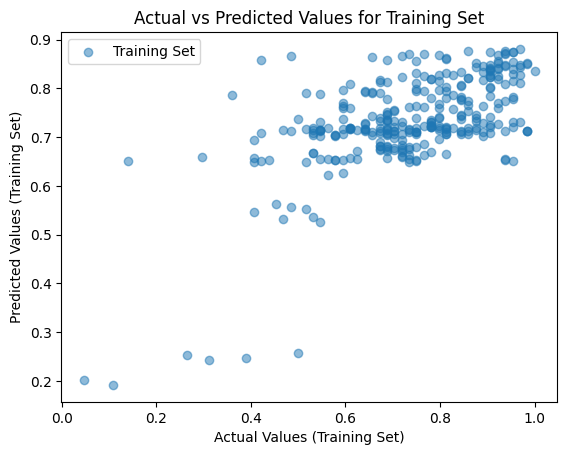

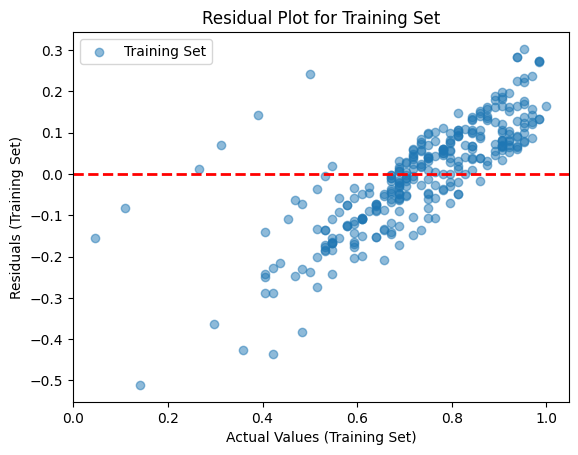

Metrics for Test set:
  MSE: 0.0177
  RMSE: 0.1332
  MAE: 0.1133
  R^2: 0.4001

Metrics for Training set:
  MSE: 0.0165
  RMSE: 0.1285
  MAE: 0.1012
  R^2: 0.3818



In [7]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
test_predictions = model(x_test)

# Convert torch tensors to NumPy arrays
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.detach().numpy()

# Plot actual vs predicted values for the test set
plt.scatter(y_test_np, test_predictions_np, alpha=0.5, label='Test Set')
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Predicted Values (Test Set)')
plt.title('Actual vs Predicted Values for Test Set')
plt.legend()
plt.show()

# Calculate residuals for the test set
test_residuals = y_test_np - test_predictions_np

# Plot residuals for the test set
plt.scatter(y_test_np, test_residuals, alpha=0.5, label='Test Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Test Set)')
plt.ylabel('Residuals (Test Set)')
plt.title('Residual Plot for Test Set')
plt.legend()
plt.show()

# Generate predictions for the training set
train_predictions = model(x_train)

# Convert torch tensors to NumPy arrays
y_train_np = y_train.numpy()
train_predictions_np = train_predictions.detach().numpy()

# Plot actual vs predicted values for the training set
plt.scatter(y_train_np, train_predictions_np, alpha=0.5, label='Training Set')
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Predicted Values (Training Set)')
plt.title('Actual vs Predicted Values for Training Set')
plt.legend()
plt.show()

# Calculate residuals for the training set
train_residuals = y_train_np - train_predictions_np

# Plot residuals for the training set
plt.scatter(y_train_np, train_residuals, alpha=0.5, label='Training Set')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Actual Values (Training Set)')
plt.ylabel('Residuals (Training Set)')
plt.title('Residual Plot for Training Set')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Print metrics for the test set
print_metrics(y_test_np, test_predictions_np, "Test")

# Print metrics for the training set
print_metrics(y_train_np, train_predictions_np, "Training")


## Now with Cross-Validation

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []
# Assuming your model, data, and metrics functions are defined previously
np.random.seed(42)
torch.manual_seed(42)
# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store evaluation metrics across folds


# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(x)):
    x_train_fold, x_test_fold = x[train_index], x[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Assuming your model is defined earlier

    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=1, out_features=500),
        nn.ReLU(),
        nn.Linear(in_features=500, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(4000):
        pre = model(x_train_fold)
        mse = mse_loss(pre, y_train_fold)
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(x_test_fold)
        mse_test = mse_loss(pre_test, y_test_fold)
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(x_test_fold).detach().numpy()
    test_mse_list.append(mean_squared_error(y_test_fold, test_predictions_fold))
    test_rmse_list.append(np.sqrt(test_mse_list[-1]))
    test_mae_list.append(mean_absolute_error(y_test_fold, test_predictions_fold))
    test_r2_list.append(r2_score(y_test_fold, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test_fold, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average RMSE: {np.mean(test_rmse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R^2: {np.mean(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0162
  RMSE: 0.1272
  MAE: 0.1015
  R^2: 0.4944


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0167
  RMSE: 0.1290
  MAE: 0.1023
  R^2: 0.2902


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0191
  RMSE: 0.1383
  MAE: 0.1114
  R^2: 0.3364


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0134
  RMSE: 0.1160
  MAE: 0.0909
  R^2: 0.2983


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0226
  RMSE: 0.1503
  MAE: 0.1180
  R^2: 0.2988


Average Metrics Across Folds:
  Average MSE: 0.0176
  Average RMSE: 0.1322
  Average MAE: 0.1048
  Average R^2: 0.3436


In [20]:
len(x)

385

In [5]:
from sklearn.model_selection import KFold
import numpy as np


from sklearn.preprocessing import MinMaxScaler
mineral = 'Density_gcm3'
hole = 'KV-NME001'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral])

two_composite_1mineral_1hole = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole]

# Calculate the mean and standard deviation for the mineral column
mean_value = two_composite_1mineral_1hole[mineral].mean()
std_dev = two_composite_1mineral_1hole[mineral].std()

# Define a threshold for values to be removed (4 standard deviations from the mean)
threshold = 2 * std_dev

# Remove rows where the mineral values are above the threshold
two_composite_1mineral_1hole = two_composite_1mineral_1hole[abs(two_composite_1mineral_1hole[mineral] - mean_value) <= threshold]    

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to your data and transform the specified columns
two_composite_1mineral_1hole[['Z', mineral]] = scaler.fit_transform(two_composite_1mineral_1hole[['Z', mineral]])



two_composite_1mineral_1hole=two_composite_1mineral_1hole.sort_values(by='Z')

x = two_composite_1mineral_1hole[['X','Y', 'Z']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = two_composite_1mineral_1hole[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(two_composite_1mineral_1hole),3)
x = x[:,2].reshape(-1,1)

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]



n_splits = 5  # You can choose the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)








# Define a list of colors for each fold
colors = ['blue', 'green', 'red', 'purple', 'orange']

mse_train_values = []  # To store training MSE for each fold
mse_test_values = []   # To store test MSE for each fold

for i, (train_indices, val_indices) in enumerate(kf.split(x)):
    x_train_fold = x[train_indices]
    y_train_fold = y[train_indices]
    x_val_fold = x[val_indices]
    y_val_fold = y[val_indices]

    model = nn.Sequential(
        nn.Linear(in_features=1, out_features=500),
        nn.ReLU(),
        nn.Linear(in_features=500, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    for step in range(10000):
        pre = model(x_train_fold)
        mse = mse_loss(pre, y_train_fold)
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Evaluate the model on the training set
        pre_train = model(x_train_fold)
        mse_train = mse_loss(pre_train, y_train_fold)
        train_losses.append(mse_train.item())

        # Evaluate the model on the validation set
        pre_val = model(x_val_fold)
        mse_val = mse_loss(pre_val, y_val_fold)
        test_losses.append(mse_val.item())

    mse_train_values.append(train_losses)
    mse_test_values.append(test_losses)

    print(f'Fold {i + 1}:')
    print(f'Training MSE: {mse_train.item():.2f}, Test MSE: {mse_val.item():.2f}')

# Calculate the mean and standard deviation of training and test MSE values across folds
mean_train_mse = np.mean(mse_train_values, axis=0)
std_train_mse = np.std(mse_train_values, axis=0)
mean_test_mse = np.mean(mse_test_values, axis=0)
std_test_mse = np.std(mse_test_values, axis=0)

print(f'Cross-validation results:')
print(f'Mean Training MSE = {mean_train_mse[-1]:.2f}, Std. Dev. Training MSE = {std_train_mse[-1]:.2f}')
print(f'Mean Test MSE = {mean_test_mse[-1]:.2f}, Std. Dev. Test MSE = {std_test_mse[-1]:.2f}')

# Create a plot of training and test errors for each fold in the same plot
plt.figure(figsize=(12, 6))
for i in range(n_splits):
    plt.plot(range(len(train_losses)), mse_train_values[i], linestyle='-', label=f'Fold {i + 1} - Training', color=colors[i], alpha=0.5)
    plt.plot(range(len(test_losses)), mse_test_values[i], linestyle='--', label=f'Fold {i + 1} - Test', color=colors[i], alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Test Errors Over Epochs for Each Fold')

# Create a plot showing only values lower than 0.03 on the y-axis
plt.figure(figsize=(12, 6))
for i in range(n_splits):
    plt.plot(range(len(train_losses)), mse_train_values[i], linestyle='-', label=f'Fold {i + 1} - Training', color=colors[i], alpha=0.5)
    plt.plot(range(len(test_losses)), mse_test_values[i], linestyle='--', label=f'Fold {i + 1} - Test', color=colors[i], alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.03)  # Set the y-axis limit to filter values under 0.03
plt.legend()
plt.title('Training and Test Errors Under 0.03 MSE')
plt.show()





models_result = np.array([model(x_test).detach().numpy() for k in range(1)])

models_result = models_result[:, :, 0]
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.figure(figsize=(14,8))
plt.scatter(x.data.numpy(), y.data.numpy(), s=4)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=4,label='Train set')



plt.plot(x_test.data.numpy()[:, 0],mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy()[:, 0],mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')



#for x_val in x_test.data.numpy()[:, 0]:
#    plt.vlines(x_val, ymin=y_test.data.numpy()[:,0].min(), ymax=y_test.data.numpy()[:,0].max(), linestyle='--', color='black', alpha=0.1)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(mineral)





Fold 1:
Training MSE: 0.01, Test MSE: 0.02
Fold 2:
Training MSE: 0.01, Test MSE: 0.01


KeyboardInterrupt: 

## All Holes

- Iteration 0, MSE : 0.09
- Iteration 1000, MSE : 0.02
- Iteration 2000, MSE : 0.02
- Iteration 3000, MSE : 0.02
- Iteration 4000, MSE : 0.02
- Iteration 5000, MSE : 0.01
- Iteration 6000, MSE : 0.01
- Iteration 7000, MSE : 0.01
- Iteration 8000, MSE : 0.01
- Iteration 9000, MSE : 0.01


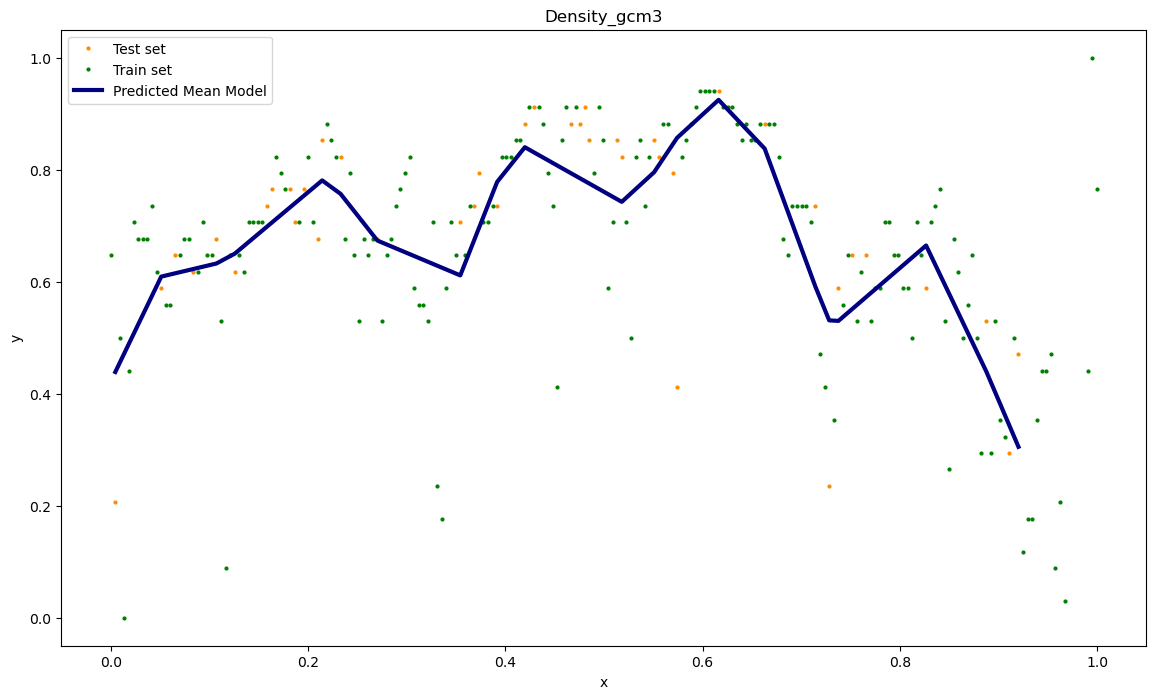

- Iteration 0, MSE : 0.07
- Iteration 1000, MSE : 0.04
- Iteration 2000, MSE : 0.03
- Iteration 3000, MSE : 0.03
- Iteration 4000, MSE : 0.03
- Iteration 5000, MSE : 0.03
- Iteration 6000, MSE : 0.03
- Iteration 7000, MSE : 0.03
- Iteration 8000, MSE : 0.03
- Iteration 9000, MSE : 0.03


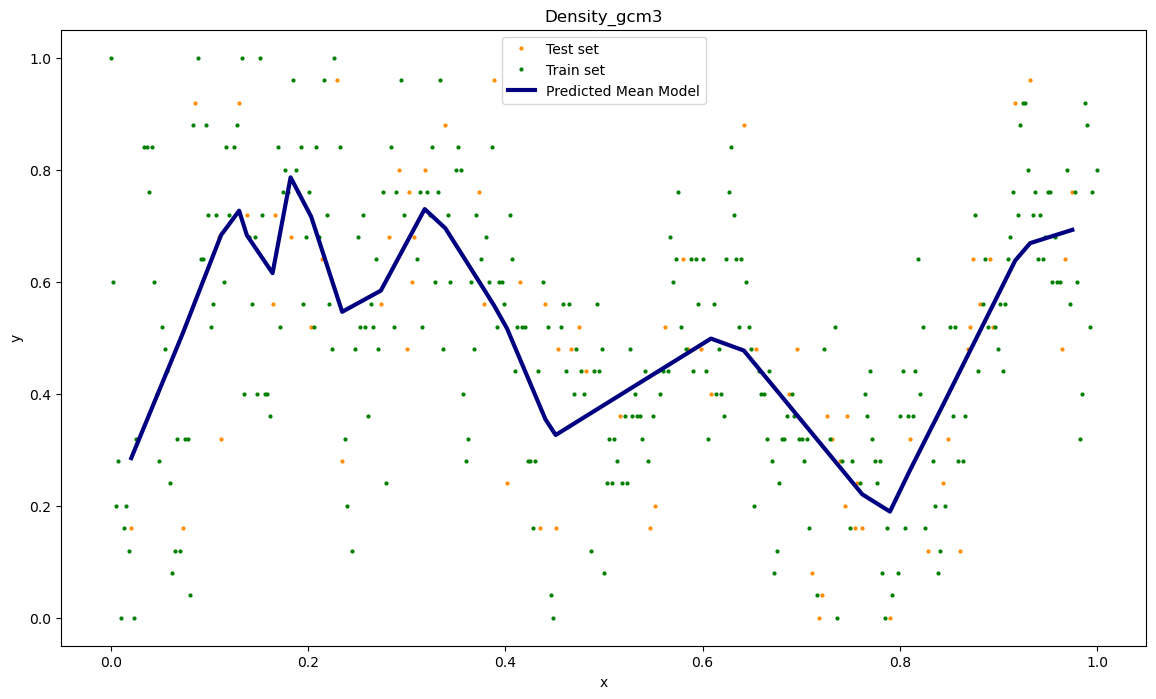

- Iteration 0, MSE : 0.25
- Iteration 1000, MSE : 0.04
- Iteration 2000, MSE : 0.03
- Iteration 3000, MSE : 0.03
- Iteration 4000, MSE : 0.03
- Iteration 5000, MSE : 0.03
- Iteration 6000, MSE : 0.03
- Iteration 7000, MSE : 0.03
- Iteration 8000, MSE : 0.03
- Iteration 9000, MSE : 0.03


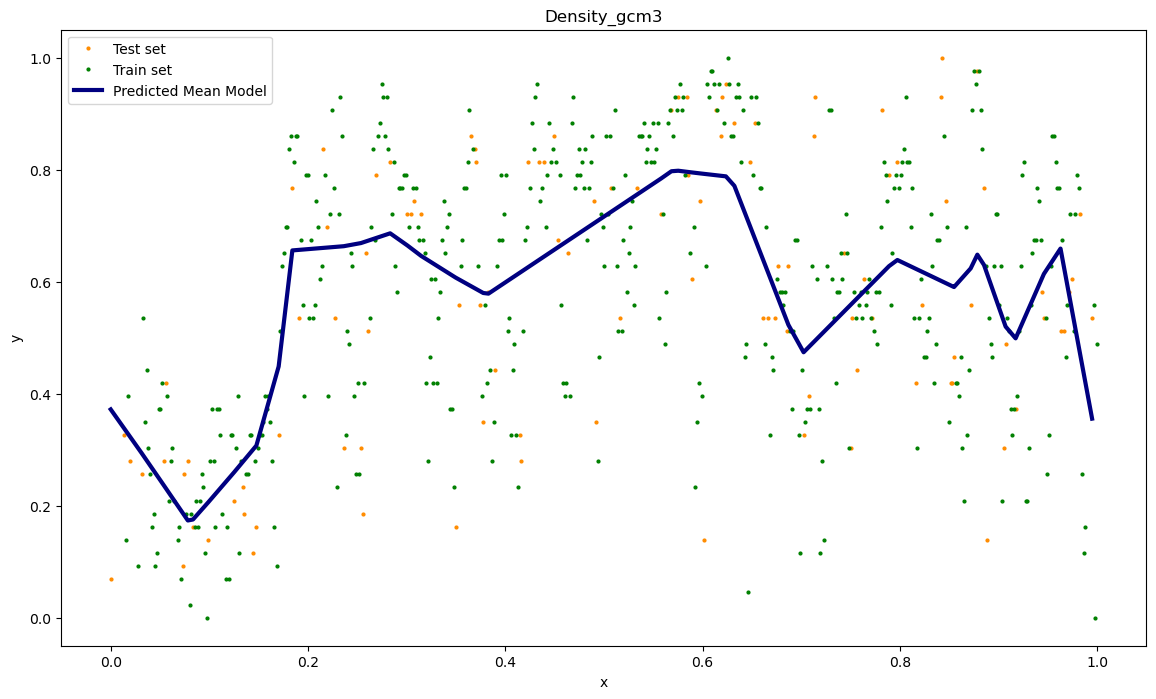

- Iteration 0, MSE : 0.33
- Iteration 1000, MSE : 0.03
- Iteration 2000, MSE : 0.03
- Iteration 3000, MSE : 0.03
- Iteration 4000, MSE : 0.03
- Iteration 5000, MSE : 0.03
- Iteration 6000, MSE : 0.03
- Iteration 7000, MSE : 0.03
- Iteration 8000, MSE : 0.02
- Iteration 9000, MSE : 0.02


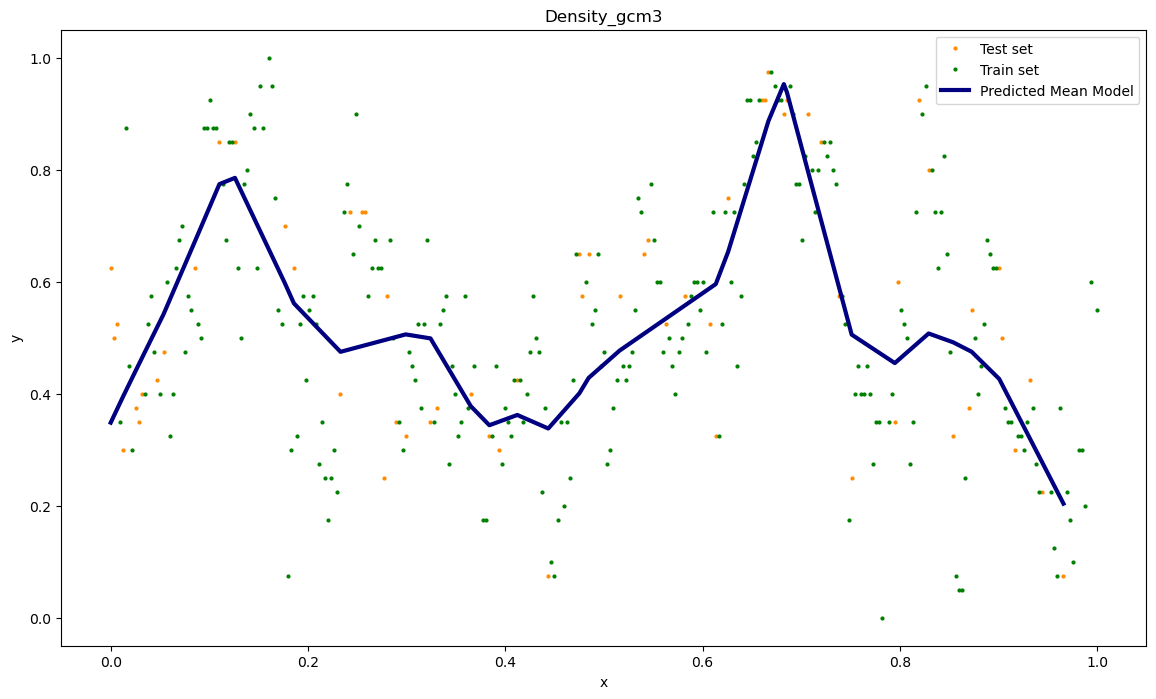

- Iteration 0, MSE : 0.63
- Iteration 1000, MSE : 0.03
- Iteration 2000, MSE : 0.03
- Iteration 3000, MSE : 0.02
- Iteration 4000, MSE : 0.02
- Iteration 5000, MSE : 0.02
- Iteration 6000, MSE : 0.02
- Iteration 7000, MSE : 0.02


KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mineral = 'Density_gcm3'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral])
for hole in two_composite_filtered['Name'].unique(): 
    two_composite_1mineral_1hole = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole]
    if len(two_composite_1mineral_1hole) < 100:
        continue
    
    # Calculate the mean and standard deviation for the mineral column
    mean_value = two_composite_1mineral_1hole[mineral].mean()
    std_dev = two_composite_1mineral_1hole[mineral].std()

    # Define a threshold for values to be removed (4 standard deviations from the mean)
    threshold = 2 * std_dev

    # Remove rows where the mineral values are above the threshold
    two_composite_1mineral_1hole = two_composite_1mineral_1hole[abs(two_composite_1mineral_1hole[mineral] - mean_value) <= threshold]    

    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Fit the scaler to your data and transform the specified columns
    two_composite_1mineral_1hole[['Z', mineral]] = scaler.fit_transform(two_composite_1mineral_1hole[['Z', mineral]])



    two_composite_1mineral_1hole=two_composite_1mineral_1hole.sort_values(by='Z')

    x = two_composite_1mineral_1hole[['X','Y', 'Z']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
    y = two_composite_1mineral_1hole[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
    x = x.reshape(len(two_composite_1mineral_1hole),3)
    x = x[:,2].reshape(-1,1)

    x = torch.tensor(x)
    y = torch.tensor(y)
    x = x.to(torch.float32)
    y = y.to(torch.float32)

    # Determine the size of the test set (e.g., 20% of the data)
    test_size = int(0.2 * len(x))

    # Generate random indices for the test set
    test_indices = np.random.choice(len(x), size=test_size, replace=False)

    # Create train and test sets based on the indices
    x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
    y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

    x_test = x[np.sort(test_indices)]
    y_test = y[np.sort(test_indices)]

    model = nn.Sequential(
    nn.Linear(in_features=1, out_features=500),  
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=1)
    )

    mse_loss = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for step in range(10000):
        pre = model(x_train)
        mse = mse_loss(pre, y_train)
        cost = mse 
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            print('- Iteration %d, MSE : %2.2f' % (step, mse.item()))
    


    models_result = np.array([model(x_test).detach().numpy() for k in range(1)])

    models_result = models_result[:, :, 0]
    models_result = models_result.T
    mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
    std_values = np.array([models_result[i].std() for i in range(len(models_result))])



    plt.figure(figsize=(14,8))
    plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=4,label='Test set')
    plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=4,label='Train set')



    plt.plot(x_test.data.numpy()[:, 0],mean_values,color='navy',lw=3,label='Predicted Mean Model')


    #for x_val in x_test.data.numpy()[:, 0]:
    #    plt.vlines(x_val, ymin=y_test.data.numpy()[:,0].min(), ymax=y_test.data.numpy()[:,0].max(), linestyle='--', color='black', alpha=0.1)

    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(mineral)
    plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

# Define your neural network architecture
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=5),  # Replace with standard Linear layer
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=1)  # Replace with standard Linear layer
)

# Create a dummy input tensor
dummy_input = torch.randn(1, 1)



# Initialize a SummaryWriter for logging
writer = SummaryWriter()

# Log the model graph to TensorBoard
writer.add_graph(model, dummy_input)

# Close the SummaryWriter when finished
writer.close()


In [ ]:

%reload_ext tensorboard
%tensorboard --logdir="C:\Users\23478671\Github\PhD-Thesis---Incorporating-Deep-Learning-into-Statistical-Models-for-Spatial-Interpolation\Paper 3 PhD BNNs for multivariate predictions" --port 5001